In [1]:
from enum import Enum
from geopy import Point
from geopy import distance
from matplotlib.pylab import plt
from scipy import stats
from scipy.spatial.distance import cdist, pdist
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture 
import geopandas as gpd
import geopy.distance
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import urllib
import urllib.request
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Determine if running in Google Colab
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_DIR = '/content/drive/MyDrive'
    COLAB = True
except:
    ROOT_DIR = '..'
    COLAB = False
    
def get_path(relative_path):
    return '{}/{}'.format(ROOT_DIR, relative_path)

In [3]:
sf = pd.read_csv(get_path('data/exports/SF_ele_single station.csv'), index_col=0)
sf.head()

,lat,lng,elevation
station_id,,,
SF-M26,37.767088,-122.407380,12
SF-M25,37.767100,-122.410662,15
SF-M26-2,37.768568,-122.404238,4
SF-L27,37.771075,-122.402732,4
SF-K26,37.771461,-122.405788,4


In [4]:
zipcode = gpd.read_file(get_path('data/shapefiles/zipcodes/san_francisco.shp'))
zipcode.head()

,area,length,po_name,state,zip,geometry
0,3.690611e+07,33638.933160,SAN FRANCISCO,CA,94103,"POLYGON ((-122.42641 37.76467, -122.42653 37.7..."
1,2.923981e+07,30323.948555,SAN FRANCISCO,CA,94109,"POLYGON ((-122.41195 37.78886, -122.41188 37.7..."
2,3.056166e+07,24300.439024,SAN FRANCISCO,CA,94115,"POLYGON ((-122.42851 37.77906, -122.42998 37.7..."
3,1.238288e+07,26722.984980,SAN FRANCISCO,CA,94105,"POLYGON ((-122.40355 37.78757, -122.40340 37.7..."
4,1.960458e+06,7187.004374,SAN FRANCISCO,CA,94104,"POLYGON ((-122.40340 37.78768, -122.40387 37.7..."


In [5]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data, weights) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [6]:
def silhouette_score_plot(data,range_n_clusters):
    X=data
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [7]:
def normalize_matrix(matrix, max=None):
    if not max:
        max = matrix.max().max()
    return matrix.div(max)

In [8]:
trips_df = pd.read_csv(get_path('data/exports/aggregated_trips_sf.csv'))
stations_df = pd.read_csv(get_path('data/exports/SF_ele_single station.csv'),
                          index_col=0)

trip_matrix = pd.read_csv(
    get_path('data/exports/adjacency_matrix/trip_count_sf.csv'), index_col=0)
classic_matrix = pd.read_csv(
    get_path('data/exports/adjacency_matrix/trip_count_classic_sf.csv'),
    index_col=0)
electric_matrix = pd.read_csv(
    get_path('data/exports/adjacency_matrix/trip_count_electric_sf.csv'),
    index_col=0)
displacement_matrix = pd.read_csv(
    get_path('data/exports/adjacency_matrix/displacement_sf.csv'), index_col=0)
elevation_matrix = pd.read_csv(
    get_path('data/exports/adjacency_matrix/elevation_sf.csv'), index_col=0)

# Normalize the unsegmented matrices.
trip_max = trip_matrix.max().max()
trip_matrix = normalize_matrix(trip_matrix)
displacement_matrix = normalize_matrix(displacement_matrix)
elevation_matrix = normalize_matrix(elevation_matrix)

# Classic and electric trips are segments of all trips. Normalize them against
# the total trip maximum instead of the total classic trip and total electric
# maxima respectively, in order to keep them on equivalent scales.
classic_matrix = normalize_matrix(classic_matrix, max=trip_max)
electric_matrix = normalize_matrix(electric_matrix, max=trip_max)

classic_reverse_matrix = classic_matrix.copy().transpose()
electric_reverse_matrix = electric_matrix.copy().transpose()

# Join displacement and elevations.
measures_matrix = displacement_matrix.join(elevation_matrix,
                                          lsuffix='_displacement',
                                          rsuffix='_elevation')
# Join classic and electric forward trips.
merged_forward_matrix = classic_matrix.join(electric_matrix,
                                            lsuffix='_classic',
                                            rsuffix='_electric')
# Join classic and electric reverse trips.
merged_reverse_matrix = electric_reverse_matrix.join(electric_reverse_matrix,
                                                     lsuffix='_classic',
                                                     rsuffix='_electric')
# Join forward and reverse trips.
merged_matrix = merged_forward_matrix.join(merged_reverse_matrix,
                                           lsuffix='_forwards',
                                           rsuffix='_reverse')
# Join trips and measures.
merged_matrix = merged_matrix.join(measures_matrix)

In [9]:
# Create weights for weighted K-means. This can be further dissected if desired.
WEIGHT_TRIP = 1.0
WEIGHT_DISPLACEMENT = 0.5
WEIGHT_ELEVATION = 0.3

M = len(trip_matrix)
weights = np.empty(M * 6)

# The first 4 matrices are trip related.
weights[0:M * 4].fill(WEIGHT_TRIP)

# The last 2 matrics are measures.
weights[M * 4:M * 5].fill(WEIGHT_DISPLACEMENT)
weights[M * 5:].fill(WEIGHT_ELEVATION)

In [10]:
def KMean_get(n, dt, weights=[]):
    rr = KMeans(n_clusters=n, random_state=0).fit(dt, weights)
    rr.labels_ = rr.predict(dt)
    clust = {dt.index[i]: rr.labels_[i] for i in range(len(rr.labels_))}
    res3 = pd.DataFrame({'id': dt.index, 'label': rr.labels_})
    return res3

In [11]:
def Kmean_range(n, dt, weights=[]):
    for n_clusters in range(2, n):  #try different numbers of clusters
        km = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = km.fit_predict(dt, weights)
        #report average Silhouette score
        silhouette_avg = silhouette_score(dt, cluster_labels)
        print("For n_clusters ={},".format(n_clusters) +
              " the average silhouette_score is :{}".format(silhouette_avg))

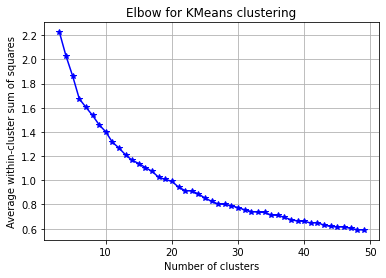

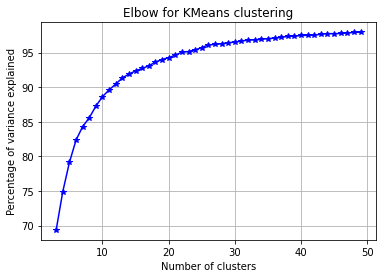

In [12]:
elbow(merged_matrix, range(3, 50))

In [13]:
Kmean_range(50, merged_matrix, weights)

For n_clusters =2, the average silhouette_score is :0.5354507154122801
For n_clusters =3, the average silhouette_score is :0.4313150248179022
For n_clusters =4, the average silhouette_score is :0.41460007359455203
For n_clusters =5, the average silhouette_score is :0.37358179647283457
For n_clusters =6, the average silhouette_score is :0.3437408299151338
For n_clusters =7, the average silhouette_score is :0.3262980290754419
For n_clusters =8, the average silhouette_score is :0.29877731581304334
For n_clusters =9, the average silhouette_score is :0.35250382334526464
For n_clusters =10, the average silhouette_score is :0.32094195349735494
For n_clusters =11, the average silhouette_score is :0.3406745999095815
For n_clusters =12, the average silhouette_score is :0.33078533888507194
For n_clusters =13, the average silhouette_score is :0.32516687481492346
For n_clusters =14, the average silhouette_score is :0.3224327291419057
For n_clusters =15, the average silhouette_score is :0.3272446166

In [14]:
# 25 clusters is also a decent local maximum, however this is more clusters than
# colors in a colormap, so the 25 clusters won't be distinguishable in the plot.
K = 9
km_result = KMean_get(K, merged_matrix, weights)
km_result = km_result.set_index('id')
labels_df = stations_df.join(km_result)

In [15]:
def plot_stations(zips_gdf, stations_gdf, column, title):
    fig, ax = plt.subplots(figsize=(15, 15))
    zips_gdf.plot(ax=ax, color='#aaa')
    stations_gdf.plot(ax=ax,
            c='label',
            cmap='Set1',
            column=column,
            edgecolor='black')
    ax.set_title(title)
    plt.show()

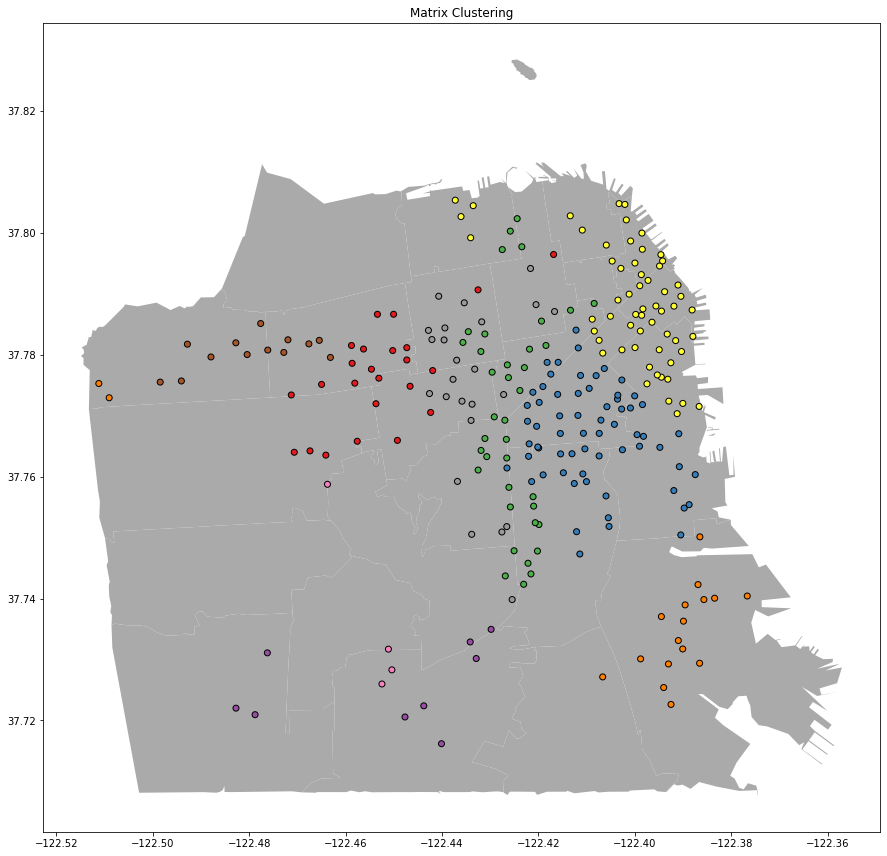

In [16]:
labels_gdf = gpd.GeoDataFrame(labels_df,
                              geometry=gpd.points_from_xy(
                                  labels_df['lng'],
                                  labels_df['lat'])).set_crs('EPSG:4326')
plot_stations(zipcode, labels_gdf, 'label', 'Matrix Clustering')

In [18]:
labels_df.reset_index()[['station_id', 'label']].to_csv(
    get_path('data/exports/cluster_labels_{}_sf.csv').format(K))

In [ ]:
# TODO (This notebook):
# 1) Gaussian mixtures
# 2) Are the weights useful?
# 3) Are clusters different when using only classic trips vs. only electric trips?
# 4) How to color lots of clusters?
# 5) How to evaluate cluster label performance?
# 6) Do weather data improve clustering?
# 7) Do temporal data improve clustering?

# TODO (Connecting notebooks):
# 8) Do cluster labels improve regression?
# 9) Does a clustered network reveal hidden trends?
# 10) How do intra-cluster and inter-cluster trips compare?
# 11) How do clustered networks compare between classic vs. electric?